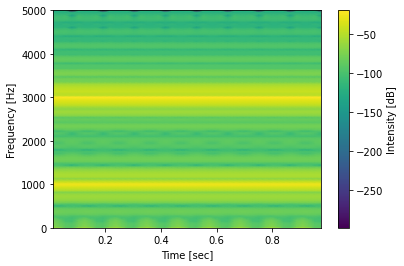

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram

# Sample data: Generate a signal
fs = 10e3
t = np.arange(0, 1.0, 1.0/fs)
x = np.sin(2*np.pi*3e3*t) + 0.5*np.sin(2*np.pi*1e3*t)

frequencies, times, Sxx = spectrogram(x, fs)

plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.colorbar(label='Intensity [dB]')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.savefig('audio.png',dpi=300)
plt.show()

/home/john/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


 Shape of X =  (200, 1, 96)
 Meta data =  {'problemname': 'ecg200', 'timestamps': False, 'missing': False, 'univariate': True, 'equallength': True, 'classlabel': True, 'targetlabel': False, 'class_values': ['-1', '1']}


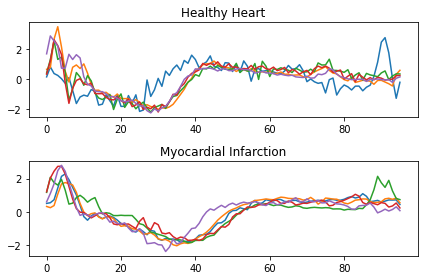

In [2]:
# Retrieve ECG dataset with Aeon
from aeon.datasets import load_classification
X, y, meta_data = load_classification("ECG200")
print(" Shape of X = ", X.shape) 
print(" Meta data = ", meta_data)

#visualize data
for i in range(10):
    if int(y[i])>0:
        plt.subplot(2,1,1)
        plt.plot(X[i,0,:])
    else:
        plt.subplot(2,1,2)
        plt.plot(X[i,0,:])
plt.subplot(2,1,1)
plt.title('Healthy Heart')
plt.subplot(2,1,2)
plt.title('Myocardial Infarction')
plt.tight_layout()
plt.savefig('heart_health.png',dpi=300)

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch import nn
from torch import optim
from ssqueezepy import cwt
from sklearn import preprocessing

# CWT with Generalzied morse wavelets
def CWT(signal):
    Wx,scales = cwt(signal,wavelet='morlet') #lots of options here
    Wx = np.abs(Wx)
    for i in range(Wx.shape[0]):
        Wx[i,:,:] = (Wx[i,:,:] - Wx[i,:,:].min()) / (Wx[i,:,:].max() - Wx[i,:,:].min())
    return Wx

# Organize Pytorch dataset into a structure that can be loaded into dataloaders
class CustomDataset(Dataset):
    def __init__(self,X,y):
        #transform
        self.preprocess = transforms.Compose([
            transforms.Resize((224,224),antialias=None)
        ])
        self.X = X; self.y = y

    def __getitem__(self,index):
        Xi = self.X[index]; yi = self.y[index]

        return self.preprocess(torch.tensor(CWT(Xi))),\
                               torch.tensor(yi).type(torch.LongTensor)

    def __len__(self):
        return len(self.X)
    
    def show(self,index):
        Xi,yi = self[index]
        nXi = Xi.numpy()
        plt.imshow(nXi[0])

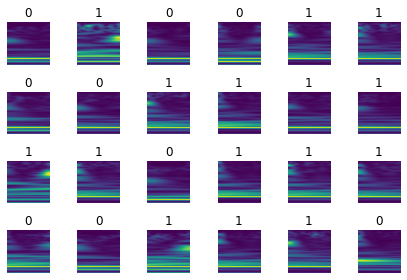

In [4]:
# transform y={-1,1} to yt={0,1}
le = preprocessing.LabelEncoder()
le.fit(y)
yt = le.transform(y)

train = CustomDataset(X, yt)

for i in range(24):
    plt.subplot(4,6,i+1)
    train.show(i)
    plt.axis('off')
    xi,yi = train[i]
    plt.title(yi.numpy())
plt.tight_layout()
plt.savefig('heart_health2.png',dpi=300)
plt.show()

In [5]:
import time
import pickle as pkl
from PIL import Image
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report
import sklearn.metrics as skm
from sklearn.model_selection import train_test_split
from aeon.datasets import load_classification

#sometimes pytorch does not play nicely with matplotlib.pyplot
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [15]:
# split data and make data loader
random_split = False
if random_split:
    xtrain,xtest,ytrain,ytest = train_test_split(X,yt,test_size=0.3)
else:
    #The original data source has already randomized the data
    split = 100
    xtrain = X[:split]
    xtest = X[split:]
    ytrain = yt[:split]
    ytest = yt[split:]

train = CustomDataset(xtrain, ytrain)
test = CustomDataset(xtest,ytest)
train_loader = DataLoader(train, batch_size=32, shuffle=True)
test_loader = DataLoader(test, batch_size=32,shuffle=True)
dataloaders = {'train' : train_loader, 'val' : test_loader}

In [7]:
# Training loop for Pytorch
def trainLoop(model,dataloaders,optimizer,
              loss_fn,n_epochs=50,
              patience=10,checkpoint='',
              verbose=0,dev='cpu',scheduler=None):
    model.to(dev)
    #set up history object
    history = {}
    for phase in dataloaders:
        history[phase+'_loss'] = np.zeros(n_epochs)
        history[phase + '_best_loss'] = 100
        history[phase + '_best_epoch'] = 0
    
    for epoch in tqdm(range(n_epochs),
                      desc='Training Model, epochs',
                      position=0):
        for phase in dataloaders:
            if phase == 'train':
                model.train(True)
            else:
                model.eval()
            running_loss = 0
            for i,data in tqdm(enumerate(dataloaders[phase]),
                               desc=f'{phase} phase',
                               total=len(dataloaders[phase]),
                               position=1,leave=False):
                inputs,labels = data
                outputs = model(inputs.to(dev))
                loss = loss_fn(outputs,labels.to(dev))
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item()
            if phase == 'train' and scheduler is not None:
                scheduler.step()
            history[phase+'_loss'][epoch] = running_loss / len(dataloaders[phase].dataset)
            if running_loss < history[phase+'_best_loss'] or epoch == 0:
                history[phase+'_best_loss'] = running_loss
                history[phase+'_best_epoch'] = epoch
            time.sleep(0.05)
            
        ### CALLBACKS
        #early stopping
        if patience != -1 and 'val' in dataloaders:
            best_epoch = history['val_best_epoch']
            if (epoch - best_epoch) > patience:
                print('no progress made in',patience,'epochs, ending training')
                if checkpoint != '':
                    model.load_state_dict(torch.load(f'{name}.ckpt'))
                return history
        #checkpoint best validation
        if checkpoint != '' and 'val' in dataloaders:
            best_epoch = history['val_best_epoch']
            if epoch == best_epoch:
                tqdm.write('best epoch, saving weights')
                torch.save(model.state_dict(), checkpoint+'.ckpt')
                pkl.dump(history,open(checkpoint+'.pkl','wb'))
        #print training
        if verbose:
            if 'val' in dataloaders:
                tqdm.write('epoch' + str(epoch) + ' training loss: ' \
                           + str(history['train_loss'][epoch]) \
                           + ' validation loss: ' + str(history['val_loss'][epoch]))
            else:
                tqdm.write('epoch' + str(epoch) + ' training loss:' \
                           + str(history['train_loss'][epoch]))
    model.to('cpu') #reset model to CPU
    if checkpoint != '':
        model.load_state_dict(torch.load(f'{name}.ckpt'))
    return history

In [8]:
#load model from torch hub
model = torch.hub.load('pytorch/vision:v0.10.0',
                       'googlenet',pretrained=True)

Using cache found in /home/john/.cache/torch/hub/pytorch_vision_v0.10.0
/home/john/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/john/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
#alter input layers to allow 64 channels
#adjust final connected layer for binary classification
model.conv1.conv = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Sequential(nn.Dropout(0.7),nn.Linear(1024,2,bias=True)) #dropout is useful since it's only 2 classes instead of 1000
model.transform_input = False

In [10]:
#set up optimizer and loss function
optimizer = optim.Adam(model.parameters(),lr=0.0001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer,0.99)
loss_fn = nn.CrossEntropyLoss()
n_epochs = 50 
patience = 5 #wait 5 epochs and cancel if it doesn't improve
verbose = 1 #show output

#use GPU if possible!
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
    
print('using device:',dev)

#name of the model
name = 'ECG_CWT_CNN'

using device: cuda:0


In [11]:
### NOTE: Due to the small dataset and the large model, this approach 
#  with this data is prone to overfitting, and can reach
#  different performance based on initialization. 

# Large CNN Models have millions of parameters and take a while to train
# For each time it loads the data, it needs to generate the CWT Images
# which also takes computational time
# expect a long training time, even with GPU acceleration
try:
    model.load_state_dict(torch.load(f'{name}.pt'))
    hist = pkl.load(open(f'{name}_hist.pkl','rb'))
except:
    hist = trainLoop(model,dataloaders,optimizer,loss_fn,
          n_epochs=n_epochs,patience=patience,checkpoint=name,verbose=verbose,dev=dev,scheduler=scheduler)
    torch.save(model.state_dict(), f'{name}.pt')
    pkl.dump(hist,open(f'{name}_hist.pkl','wb'))
model.to('cpu')
print('train')

train


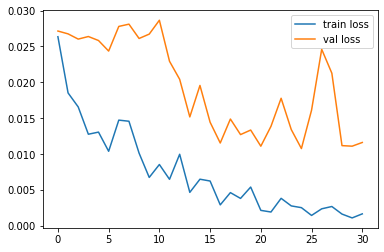

In [12]:
lasti = hist['train_loss'].argmin()
plt.plot(hist['train_loss'][:lasti],label='train loss')
plt.plot(hist['val_loss'][:lasti],label='val loss')
plt.legend()

In [13]:
ypred = []
ytrue = []
for data in dataloaders['train']:
    xi,yi = data
    pred = model(xi).argmax(axis=1)
    ypred.extend(pred.numpy())
    ytrue.extend(yi.numpy())
print('total accuracy:',skm.accuracy_score(ytrue,ypred))
print(classification_report(ytrue,ypred))

total accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        31
           1       1.00      1.00      1.00        69

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [14]:
ypred = []
ytrue = []
for data in dataloaders['val']:
    xi,yi = data
    pred = model(xi).argmax(axis=1)
    ypred.extend(pred.numpy())
    ytrue.extend(yi.numpy())
print('total accuracy:',skm.accuracy_score(ytrue,ypred))
print(classification_report(ytrue,ypred))

total accuracy: 0.79
              precision    recall  f1-score   support

           0       0.76      0.61      0.68        36
           1       0.80      0.89      0.84        64

    accuracy                           0.79       100
   macro avg       0.78      0.75      0.76       100
weighted avg       0.79      0.79      0.78       100

